In [ ]:
!pip install langchain
!pip install pinecone-client

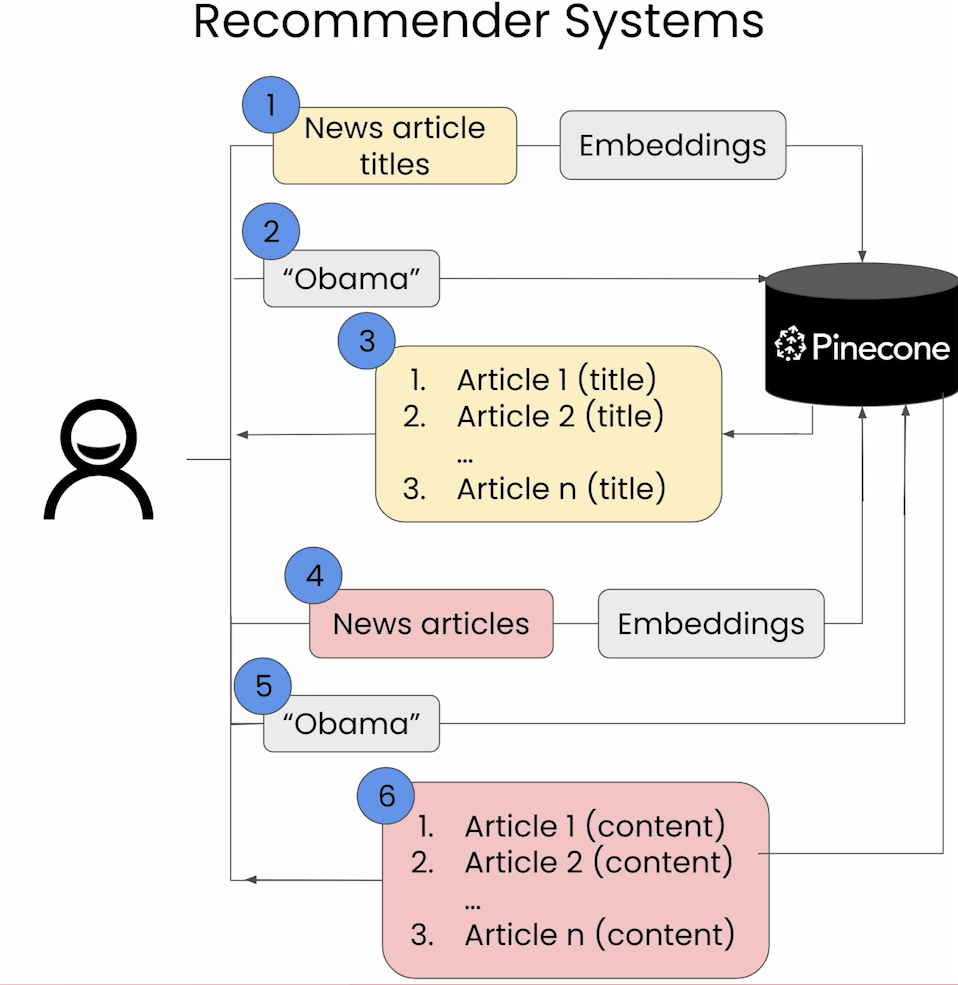

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
# basics
import os
import ast
import json
import requests
import numpy as np
import pandas as pd

import http.client
from tqdm.auto import tqdm

import torch
from pinecone import Pinecone, ServerlessSpec
from langchain.text_splitter import RecursiveCharacterTextSplitter

# dotenv files
from google.colab import userdata

In [29]:
def generate_embeddings(model_id, input_text):
    """
    Generate embeddings for the given input text using IBM embedding models.

    Args:
    model_id (str): The ID of the model to use for generating embeddings.
    input_text (str): The input text for which to generate embeddings.

    Returns:
    list: The generated embeddings or an error message.
    """

    # Get API key and URL from environment variables
    api_key = userdata.get("GENAI_KEY")
    api_url = userdata.get("GENAI_API")

    if not api_key or not api_url:
        raise ValueError("API key or URL not found in environment variables")

    endpoint = "/v2/text/embeddings?version=2024-04-15"
    url = f"{api_url}{endpoint}"

    payload = {
        "model_id": model_id,
        "input": input_text
    }

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    response = requests.post(url, headers=headers, data=json.dumps(payload))

    if response.status_code == 200:
        data = response.json()
        embedding = data['results'][0]['embedding']
        return np.array(embedding)
    else:
        return {
            "error": f"Error: {response.status_code}",
            "message": response.text
        }


In [5]:
# check embedding
generate_embeddings("ibm/slate.125m.english.rtrvr", input_text="Write a tagline for an alumni association: Together we").shape

(768,)

In [6]:
# loading the data
!wget -q --show-progress -O all-the-news-3.zip "https://www.dropbox.com/scl/fi/wruzj2bwyg743d0jzd7ku/all-the-news-3.zip?rlkey=rgwtwpeznbdadpv3f01sznwxa&dl=1"

!unzip all-the-news-3.zip

all-the-news-3.zip  100%[===================>] 166.04M   114MB/s    in 1.5s    
Archive:  all-the-news-3.zip
  inflating: all-the-news-3.csv      


In [7]:
with open('/content/all-the-news-3.csv', 'r') as f:
    header = f.readline()
    print(header)

date,year,month,day,author,title,article,url,section,publication



In [8]:
df = pd.read_csv('/content/all-the-news-3.csv', nrows=100)
df.head()

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters
3,2019-06-27 00:00:00,2019,6.0,27,NaN,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,https://www.reuters.com/article/france-politic...,World News,Reuters
4,2016-01-27 00:00:00,2016,1.0,27,NaN,Paris Hilton: Woman In Black For Uncle Monty's...,Paris Hilton arrived at LAX Wednesday dressed ...,https://www.tmz.com/2016/01/27/paris-hilton-mo...,NaN,TMZ


In [9]:
# setting up pinecone.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    print("GPU not available")
    print('=' * 50)
else:
    print("GPU available\n\n")
    print('=' * 50)

# access pinecone apikey
pinecone = Pinecone(api_key=userdata.get("PINECONE_API_KEY"))
INDEX_NAME = "recommender-news-data-index"

# delete existing index, if exists
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    print(f"Index {INDEX_NAME} already exists")
    print('=' * 50)
    pinecone.delete_index(INDEX_NAME)
    print(f"Index {INDEX_NAME} deleted")
else:
    print(f"Index {INDEX_NAME} does not exist")


GPU not available
Index recommender-news-data-index already exists
Index recommender-news-data-index deleted


In [10]:
# Create a new index with the specified name, dimension, and metric
pinecone.create_index(
    name=INDEX_NAME,
    dimension= 768,  # model embedding dimensions
    metric="cosine",  # search metric
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)

pinecone_index = pinecone.Index(INDEX_NAME)
print(f'Index Created: \n----------------------------\n{INDEX_NAME}\n----------------------------')
print(pinecone_index)

Index Created: 
----------------------------
recommender-news-data-index
----------------------------


### Create Embedding of the News Titles

In [11]:
df = pd.read_csv('/content/all-the-news-3.csv', on_bad_lines='skip', engine='python', nrows=1000)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1000 non-null   object 
 1   year         1000 non-null   int64  
 2   month        1000 non-null   float64
 3   day          1000 non-null   int64  
 4   author       694 non-null    object 
 5   title        1000 non-null   object 
 6   article      998 non-null    object 
 7   url          1000 non-null   object 
 8   section      441 non-null    object 
 9   publication  1000 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 78.2+ KB


In [13]:
# upserting one record at a time
def upsert_to_pinecone(index, record_id, title, embedding, first_record=False):
    index.upsert(
        vectors=[
            {"id": str(record_id), "values": embedding.tolist(), "metadata": {"title": title}}
        ]
    )
    if first_record:
        print(f"Successfully upserted record ID: {record_id} \n\nwith title: '{title}'")
        print('='*50)

In [ ]:
# Example: Upsert all records into a namespace
model_id = "ibm/slate.125m.english.rtrvr"  # Use your specific model ID

first_record = True
for idx, record in tqdm(df.iterrows(), total=df.shape[0]):
    title = record['title']
    embedding = generate_embeddings(model_id, title)
    if isinstance(embedding, np.ndarray):
        upsert_to_pinecone(pinecone_index, idx, title, embedding, first_record)
        if first_record:
            first_record = False
    else:
        print(f"Error generating embedding for record index {idx}: {embedding}")

In [20]:
pinecone_index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

### News Title Recommender System

In [26]:
# use embedding model, embed new search term, and query DB for results
new_search_query = generate_embeddings(model_id = model_id, input_text = 'President Barack Obama')

if isinstance(new_search_query, np.ndarray):
    new_search_query = new_search_query.tolist()

query_results = pinecone_index.query(
    vector=new_search_query,
    top_k=3,
    include_metadata=True)

In [27]:
query_results

{'matches': [{'id': '558',
              'metadata': {'title': 'The best analogy to Donald Trump in 2017 '
                                    'is George W. Bush in 2005'},
              'score': 0.622953951,
              'values': []},
             {'id': '911',
              'metadata': {'title': 'In separate speeches Obama, Biden, Carter '
                                    'target Trump policies'},
              'score': 0.586730957,
              'values': []},
             {'id': '477',
              'metadata': {'title': "Obama-Trump meeting 'less awkward' than "
                                    'some might have expected: White House'},
              'score': 0.58054328,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}

### Now Lets Build Embeddings of the Entire Article

In [14]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  print(f"Index {INDEX_NAME} already exists")
  print('=' * 50)
  pinecone.delete_index(name=INDEX_NAME)
  print(f"Index {INDEX_NAME} deleted")
else:
  print(f"Index {INDEX_NAME} does not exist")

Index recommender-news-data-index already exists
Index recommender-news-data-index deleted


In [15]:
pinecone.create_index(name=INDEX_NAME, dimension=768, metric="cosine",
  spec=ServerlessSpec(cloud="aws", region="us-east-1"))
pinecone_index = pinecone.Index(name=INDEX_NAME)
print(f'Index Created: \n----------------------------\n{INDEX_NAME}\n----------------------------')

Index Created: 
----------------------------
recommender-news-data-index
----------------------------


In [16]:
def embed_and_upsert(embeddings, title, url, upsert_list, embed_num, index, batch_size=100):
    """
    Embed and upsert the embeddings to Pinecone index in batches.

    Args:
        embeddings (list): A list of embedding vectors.
        title (str): The title associated with the embeddings.
        url (str): The URL associated with the article.
        upsert_list (list): A list to store the records to be upserted.
        embed_num (int): A counter to generate unique IDs for the embeddings.
        index (pinecone.Index): The Pinecone index to upsert the embeddings.
        batch_size (int): The size of each upsert batch.

    Returns:
        int: The updated embed_num counter.
    """
    for embedding in embeddings:
        upsert_list.append({
            'id': str(embed_num),
            'values': embedding,
            'metadata': {'title': title, 'url': url}
        })
        embed_num += 1

        # Perform upsert in batches
        if len(upsert_list) >= batch_size:
            index.upsert(upsert_list)
            upsert_list.clear()

    return embed_num

In [21]:
# slice data and use segments whee we'd want to embed
df = df.iloc[:10]

urls_list = df['url'].tolist()
titles_list = df['title'].tolist()
articles_list = df['article'].tolist()

In [22]:
# Initialize the text splitter from LangChain
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=20)

In [ ]:
%%time
model_id = "ibm/slate.125m.english.rtrvr"  # Use your specific model ID
embed_num = 0  # Keep track of embedding number for 'id'
batch_size = 5  # Define batch size
upsert_list = []

for i in tqdm(range(len(articles_list))):
    art = articles_list[i]
    title = titles_list[i]
    url = urls_list[i]
    if art is not None and isinstance(art, str):
        texts = text_splitter.split_text(art)
        embeddings = [generate_embeddings(model_id, text) for text in texts]
        embed_num = embed_and_upsert(embeddings, title, url, upsert_list, embed_num, pinecone_index, batch_size)

# Ensure to upsert any remaining records
if upsert_list:
    pinecone_index.upsert(upsert_list)

In [24]:
pinecone_index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 950}},
 'total_vector_count': 950}

### News Article Recommender System

In [26]:
def get_recommendations(index, query_text, top_k=3):
    """
    Query the Pinecone index to get recommendations.

    Args:
        index (pinecone.Index): The Pinecone index to query.
        query_text (str): The query text to search for.
        top_k (int): The number of top recommendations to return.

    Returns:
        object: The recommendations returned by the Pinecone query.
    """
    # Generate embedding for the query text
    query_embedding = generate_embeddings(model_id, query_text)

    if isinstance(query_embedding, np.ndarray):
        query_embedding = query_embedding.tolist()

    # Query the Pinecone index
    query_results = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_metadata=True
    )

    return query_results

In [28]:
# Get and print recommendations
reco = get_recommendations(pinecone_index, 'Obama', top_k=3)
seen = {}
for r in reco.matches:
    title = r.metadata['title']
    url = r.metadata['url']
    if title not in seen:
        print(f'{r.score} : {title} \nURL: {url}')
        seen[title] = '.'

0.599337459 : Nancy Pelosi says a Clinton landslide could put the House in play. The math backs her up. 
URL: https://www.vox.com/2016/9/8/12847958/house-democrats-clinton
0.594991326 : NYPD Honcho Insulted by 'Hamilton' Star Lin-Manuel Miranda Celebrating Obama's Controversial Prisoner Release 
URL: https://www.tmz.com/2017/01/18/lin-manuel-miranda-obama-commutes-oscar-lopez-rivera-sentence/


In [38]:
# Extract URL with the highest score from the recommendations
highest_score_match = max(reco['matches'], key=lambda x: x['score'])
highest_score_url = highest_score_match['metadata']['url']
print(f"URL with the highest score: {highest_score_url}")

URL with the highest score: https://www.vox.com/2016/9/8/12847958/house-democrats-clinton


### Lets ask LLM to summarize the article for us!

In [49]:
# Load environment variables
api_key = userdata.get("GENAI_KEY")
api_url = userdata.get("GENAI_API")

# Establish connection
conn = http.client.HTTPSConnection(api_url)

# Headers for the request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Define the model ID
model_id = "meta-llama/llama-3-70b-instruct"

# Prompt for summarizing an article
prompt = """
You are an AI assistant. Your task is to summarize the content of the article from the given URL.

URL: {{URL}}

Please provide a concise summary of the article content.
"""

In [50]:
def create_payload(url):
    return json.dumps(
        {
            "model_id": model_id,
            "parameters": {
                "decoding_method": "sample",
                "temperature": 0.7,
                "top_k": 10,
                "length_penalty": {"decay_factor": 1.5, "start_index": 100},
                "max_new_tokens": 250,
            },
            "moderations": {},
            "input": "user\n\n" + prompt.replace("{{URL}}", url) + "\n\nassistant",
            "data": {}
        }
    )

In [55]:
def summarize_article(url):
    payload = create_payload(url)
    conn.request("POST", "/v2/text/generation?version=2024-03-19", body=payload, headers=headers)
    response = conn.getresponse()
    data = response.read().decode('utf-8')
    result = json.loads(data)
    if response.status == 200:
        return result['results'][0]['generated_text']
    else:
        raise Exception(f"Error: {response.status}, {result}")

# Summarize the article with the highest score
summary = summarize_article(highest_score_url)
pprint.pprint(summary)

('<|end_header_id|>\n'
 '\n'
 'Here is a concise summary of the article:\n'
 '\n'
 'The article discusses how House Democrats are rallying around Hillary '
 'Clinton in the ,2016 presidential election. Despite some initial '
 'reservations, Democrats in the House of Representatives are increasingly '
 "confident in Clinton's ability to win the presidency and are working to help "
 'her campaign. They see her as a strong candidate who can unite the party and '
 'appeal to a broad coalition of voters. The article highlights how Democrats '
 "are impressed by Clinton's policy knowledge, her ability to connect with "
 'voters, and her potential to make')
